# Experiment - Financial PhraseBank

In [4]:
NAME = '09-01_experiment_financial_phrasebank'
PROJECT = 'conference-calls-sentiment'
PYTHON_VERSION = '3.7.0'

### Imports

In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from utils import accuracy_f1_score, plot_confusion_matrix

# FinBERT
import torch
from torch.utils.data import TensorDataset, DataLoader
from finbert_utils import preprocess_for_finbert, finbert_predict

Using GPU GeForce GTX 1060 6GB


### Settings

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [5]:
workdir = re.sub("(?<={})[\w\W]*".format(PROJECT), "", os.getcwd())
os.chdir(workdir)

pipeline = os.path.join('2_pipeline', NAME)
if not os.path.exists(pipeline):
    os.makedirs(pipeline)
    for folder in ['out', 'store', 'tmp']:
        os.makedirs(os.path.join(pipeline, folder))

---
# Main Code 

## Labeled sentences Malo et al. (2014)

In [6]:
def read_labeled_sentences(level):
    with open(os.path.join('0_data', 'financial_phrasebank', f'Sentences_{level}Agree.txt')) as f:
        labeled_sentences = f.readlines()
    sentences, labels = [], []
    for i in labeled_sentences:
        sentence, label = i.split(('@'))
        sentences.append(sentence)
        labels.append(label.strip())
    return pd.DataFrame({'sentence': sentences, 'label': labels})

## Models
### Harvard IV-4

In [7]:
with open(os.path.join('2_pipeline', '03-01_model_dictionaries', 'out', 'iv4_positive.pickle'), 'rb') as f:
    iv4_positive = pickle.load(f)

with open(os.path.join('2_pipeline', '03-01_model_dictionaries', 'out', 'iv4_negative.pickle'), 'rb') as f:
    iv4_negative = pickle.load(f)

print(f"# Positive: {len(iv4_positive)}\n# Negative: {len(iv4_negative)}")

# Positive: 1563
# Negative: 1892


### Loughran & McDonald (2011)

In [8]:
with open(os.path.join('2_pipeline', '03-01_model_dictionaries', 'out', 'lm_positive.pickle'), 'rb') as f:
    lm_positive = pickle.load(f)

with open(os.path.join('2_pipeline', '03-01_model_dictionaries', 'out', 'lm_negative.pickle'), 'rb') as f:
    lm_negative = pickle.load(f)

print(f"# Positive: {len(lm_positive)}\n# Negative: {len(lm_negative)}")

# Positive: 354
# Negative: 2355


### FinBERT

In [9]:
FINBERT_VOCAB = os.path.join('0_data', 'finbert', 'finbert_vocab')
finbert = torch.load(os.path.join('2_pipeline', '03-02_model_finbert', 'out', 'finbert'))

## Functions

In [10]:
def count_from_list(sentence, word_list):
    '''Returns the count of words in word_list in conference calls'''
    sentence_words = sentence.lower().split()
    num = 0
    for word in word_list:
        num += sentence_words.count(word)
    return num

def get_sentiment(row):
    '''Returns the sentiment classification'''
    if row['num_positive'] == row['num_negative']:
        return 'neutral'
    elif row['num_positive'] > row['num_negative']:
        return 'positive'
    else:
        return 'negative'

## All Agree

In [11]:
all_agree = read_labeled_sentences('All')
len(all_agree)

2264

### Harvard IV-4

Accuracy: 54.59%
F1-score: 54.87%


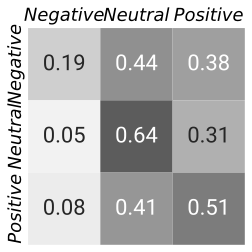

In [12]:
all_agree['num_negative'] = all_agree['sentence'].apply(count_from_list, word_list=iv4_negative)
all_agree['num_positive'] = all_agree['sentence'].apply(count_from_list, word_list=iv4_positive)

all_agree['iv4_dictionary'] = all_agree.apply(get_sentiment, axis=1)

# Output
accuracy_f1_score(all_agree['label'], all_agree['iv4_dictionary'])
plot_confusion_matrix(all_agree['label'], all_agree['iv4_dictionary'])

### Loughran & McDonald

Accuracy: 65.02%
F1-score: 59.96%


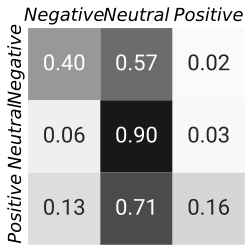

In [13]:
all_agree['num_negative'] = all_agree['sentence'].apply(count_from_list, word_list=lm_negative)
all_agree['num_positive'] = all_agree['sentence'].apply(count_from_list, word_list=lm_positive)

all_agree['lm_dictionary'] = all_agree.apply(get_sentiment, axis=1)

# Output
accuracy_f1_score(all_agree['label'], all_agree['lm_dictionary'])
plot_confusion_matrix(all_agree['label'], all_agree['lm_dictionary'])

### FinBERT

100%|██████████| 36/36 [00:11<00:00,  3.14it/s]
Accuracy: 91.65%
F1-score: 91.36%


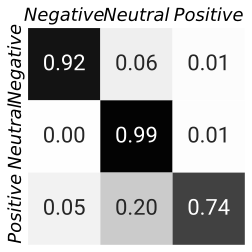

In [15]:
# Preprocess
input_ids, token_type_ids, attention_masks = preprocess_for_finbert(all_agree['sentence'], vocab_file=FINBERT_VOCAB)
dataset = TensorDataset(input_ids, token_type_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=64)

# Predict
all_agree['FinBERT'] = finbert_predict(finbert, dataloader)

# Output
accuracy_f1_score(all_agree['label'], all_agree['FinBERT'])
plot_confusion_matrix(all_agree['label'], all_agree['FinBERT'])

### Output

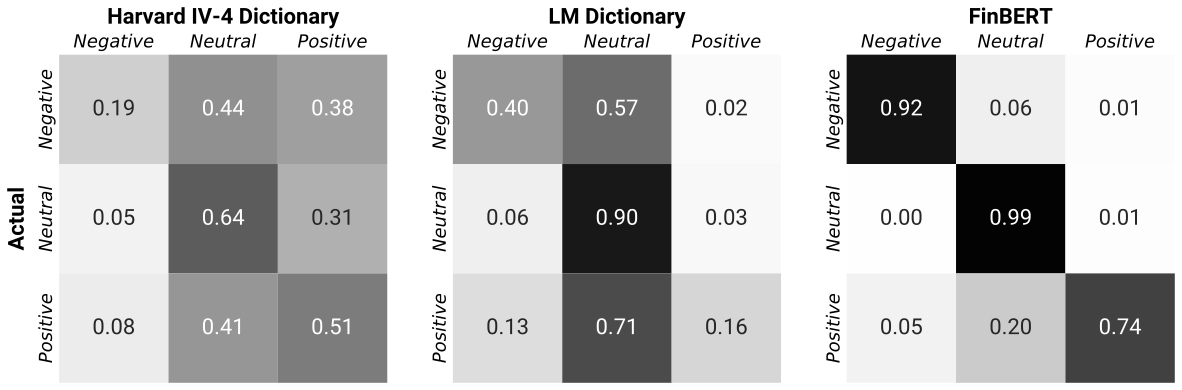

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 8), facecolor='w')
plot_confusion_matrix(all_agree['label'], all_agree['iv4_dictionary'], xlabel='Harvard IV-4 Dictionary', ylabel='Actual', ax=axes[0])
plot_confusion_matrix(all_agree['label'], all_agree['lm_dictionary'], xlabel='LM Dictionary', ax=axes[1])
plot_confusion_matrix(all_agree['label'], all_agree['FinBERT'], xlabel='FinBERT', ax=axes[2])
fig.savefig(os.path.join('3_output', 'figures', 'financial_phrasebank_cm.pdf'), bbox_inches='tight')

## 50% Agree

In [17]:
half_agree = read_labeled_sentences('50')
len(half_agree)

4846

### Harvard IV-4

Accuracy: 52.79%
F1-score: 53.18%


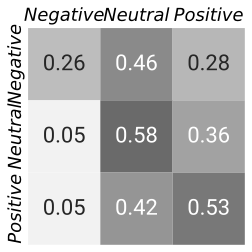

In [18]:
half_agree['num_negative'] = half_agree['sentence'].apply(count_from_list, word_list=iv4_negative)
half_agree['num_positive'] = half_agree['sentence'].apply(count_from_list, word_list=iv4_positive)

half_agree['iv4_dictionary'] = half_agree.apply(get_sentiment, axis=1)

# Output
accuracy_f1_score(half_agree['label'], half_agree['iv4_dictionary'])
plot_confusion_matrix(half_agree['label'], half_agree['iv4_dictionary'])

### Loughran & McDonald

Accuracy: 62.57%
F1-score: 59.29%


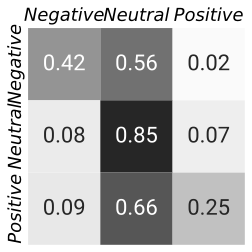

In [20]:
half_agree['num_negative'] = half_agree['sentence'].apply(count_from_list, word_list=lm_negative)
half_agree['num_positive'] = half_agree['sentence'].apply(count_from_list, word_list=lm_positive)

half_agree['lm_dictionary'] = half_agree.apply(get_sentiment, axis=1)

# Output
accuracy_f1_score(half_agree['label'], half_agree['lm_dictionary'])
plot_confusion_matrix(half_agree['label'], half_agree['lm_dictionary'])

### FinBERT

100%|██████████| 76/76 [00:23<00:00,  3.17it/s]
Accuracy: 79.24%
F1-score: 78.42%


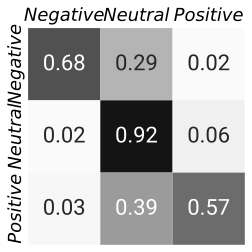

In [21]:
# Preprocess
input_ids, token_type_ids, attention_masks = preprocess_for_finbert(half_agree['sentence'], vocab_file=FINBERT_VOCAB)
dataset = TensorDataset(input_ids, token_type_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=64)

# Predict
half_agree['FinBERT'] = finbert_predict(finbert, dataloader)

# Output
accuracy_f1_score(half_agree['label'], half_agree['FinBERT'])
plot_confusion_matrix(half_agree['label'], half_agree['FinBERT'])

### Output

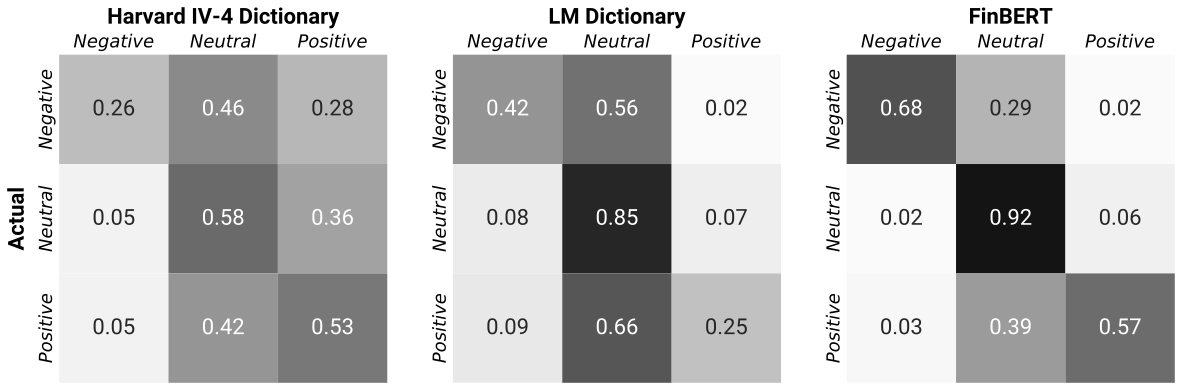

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 8), facecolor='w')
plot_confusion_matrix(half_agree['label'], half_agree['iv4_dictionary'], xlabel='Harvard IV-4 Dictionary', ylabel='Actual', ax=axes[0])
plot_confusion_matrix(half_agree['label'], half_agree['lm_dictionary'], xlabel='LM Dictionary', ax=axes[1])
plot_confusion_matrix(half_agree['label'], half_agree['FinBERT'], xlabel='FinBERT', ax=axes[2])
fig.savefig(os.path.join('3_output', 'figures', 'financial_phrasebank_50_cm.pdf'), bbox_inches='tight')

---
# Analyses

In [20]:
def seach_sentences(df, label, dictionary, finbert):
    return df.loc[(df['label'] == label) &
                  (df['lm_dictionary'] == dictionary) &
                  (df['FinBERT'] == finbert), 'sentence']

### LM Dictionary Mistakes

In [ ]:
with pd.option_context('display.max_colwidth', -1):
    display(seach_sentences(half_agree, 'positive', 'negative', 'positive'))

6       For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .                                                                           
15      Consolidated net sales increased 16 % to reach EUR74 .8 m , while operating profit amounted to EUR0 .9 m compared to a loss of EUR0 .7 m in the prior year period .                                                                                                         
17      HELSINKI ( AFX ) - Shares closed higher , led by Nokia after it announced plans to team up with Sanyo to manufacture 3G handsets , and by Nokian Tyres after its fourth-quarter earnings report beat analysts ' expectations , dealers said .                               
20      Lifetree was founded in 2000 , and its revenues have risen on an average by 40 % with margins in late 30s .                                                      

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
    display(seach_sentences(half_agree, 'negative', 'positive', 'negative'))

1709    IT services firm TietoEnator was bucking the general trend , holding flat at 22.70 eur , after slipping back from earlier gains .                                                                          
1714    TeliaSonera 's underlying results however included 457 mln skr in positive one-offs , hence the adjusted underlying EBITDA actually amounts to 7.309 bln skr , clearly below expectations , analysts said .
1937    Shares in Royal and Sun Alliance continued to slide back from a 12-month high of 172p last month , after a potential suitor ruled itself out of a takeover bid .                                           
4532    `` Adjustment to the fall in price level , in contrast , has been less effective .                                                                                                                         
4783    Currently , the company foresees its pre-tax profit to remain below the 2009 level when it reached EUR 700,000 USD 934,000 , compared with previ

### FinBERT mistakes

In [22]:
with pd.option_context('display.max_colwidth', -1):
    display(seach_sentences(half_agree, 'positive', 'positive', 'neutral'))

551     Marimekko has today ( 20 November ) signed a license agreement with the Swedish chain , whereby Marimekko will license some of its popular patterns from the 1950s , 1960s and 1970s to H&M .                                       
556     STX Finland Oy signed a a preliminary agreement for the building of an environmentally friendly , new generation cruise ferry for Viking Line to manage on between Turku , Finland , and Stockholm , Sweden withViking Line ABP .   
607     Progress Group , QPR 's representative in Saudi Arabia and North Africa , has signed a framework agreement for a long term strategic relationship with ISE .                                                                        
611     In addition , Cramo and Peab have signed exclusive five-year rental agreements in Finland and have extended their existing rental agreements in the Swedish market for another five years .                                         
769     Major Order in India Comptel Corporation has